In [ ]:
import os,yaml,argparse
import pytorch_lightning as pl
from tbsim.utils.batch_utils import set_global_batch_type
from tbsim.utils.trajdata_utils import set_global_trajdata_batch_env, set_global_trajdata_batch_raster_cfg
from datetime import  datetime
from tbsim.datasets.trajdata_datamodules import PassUnifiedDataModule
from configs.custom_config import dict_to_config,ConfigBase
from tbsim.configs.base import ExperimentConfig
from utils.trainer_utils import prepare_trainer_and_data
from tbsim.utils.trajdata_utils import set_global_trajdata_batch_env, set_global_trajdata_batch_raster_cfg
from tbsim.utils.batch_utils import batch_utils
from tbsim.utils.batch_utils import set_global_batch_type
from tbsim.utils.config_utils import translate_pass_trajdata_cfg
import matplotlib.patches as patches

from tbsim.utils.batch_utils import batch_utils
import matplotlib.pyplot as plt
import numpy as np
from tbsim.utils.scene_edit_utils import get_agt_color
COLORS = {
    "agent_contour": "#247BA0",
    "agent_fill": "#56B1D8",
    "ego_contour": "#911A12",
    "ego_fill": "#FE5F55",
}

import tbsim.utils.geometry_utils as GeoUtils

from l5kit.geometry import transform_points
import tbsim.utils.geometry_utils as GeoUtils
import torch


In [ ]:
parser = argparse.ArgumentParser(description="Training Script")
parser.add_argument("--config", type=str, default="./config.yaml", help="Path to YAML config")
args = parser.parse_args([])
with open(args.config, "r") as f:
    config_dict = yaml.safe_load(f)
train_config = dict_to_config(ConfigBase, config_dict.get("train", {}))
env_config = dict_to_config(ConfigBase, config_dict.get("env", {}))
algo_config = dict_to_config(ConfigBase, config_dict.get("algo", {}))
default_config = ExperimentConfig(
    train_config=train_config,
    env_config=env_config,
    algo_config=algo_config,
    registered_name=config_dict.get("registered_name", "default_experiment"),
)
  
default_config.lock()
cfg = default_config
pl.seed_everything(default_config.seed)
set_global_batch_type("trajdata")
set_global_trajdata_batch_env(default_config.train.trajdata_source_train[0])
set_global_trajdata_batch_raster_cfg(default_config.env.rasterizer)

trajdata_config = translate_pass_trajdata_cfg(cfg)
datamodule = PassUnifiedDataModule(trajdata_config, cfg.train)
datamodule.setup()

In [3]:
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))

batch =batch_utils().parse_batch(batch)
batch.keys()


dict_keys(['data_idx', 'scene_ts', 'dt', 'agent_name', 'agent_type', 'curr_agent_state', 'agent_hist', 'agent_hist_extent', 'agent_hist_len', 'agent_fut', 'agent_fut_extent', 'agent_fut_len', 'num_neigh', 'neigh_indices', 'neigh_types', 'neigh_hist', 'neigh_hist_extents', 'neigh_hist_len', 'neigh_fut', 'neigh_fut_extents', 'neigh_fut_len', 'robot_fut_len', 'map_names', 'maps', 'maps_resolution', 'vector_maps', 'rasters_from_world_tf', 'agents_from_world_tf', 'scene_ids', 'history_pad_dir', 'extras', 'image', 'drivable_map', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_speeds', 'history_availabilities', 'curr_speed', 'centroid', 'yaw', 'type', 'extent', 'raster_from_agent', 'agent_from_raster', 'raster_from_world', 'agent_from_world', 'world_from_agent', 'all_other_agents_indices', 'all_other_agents_history_positions', 'all_other_agents_history_yaws', 'all_other_agents_history_speeds', 'all_other_agents_history_availabilities'

torch.Size([1182, 2])

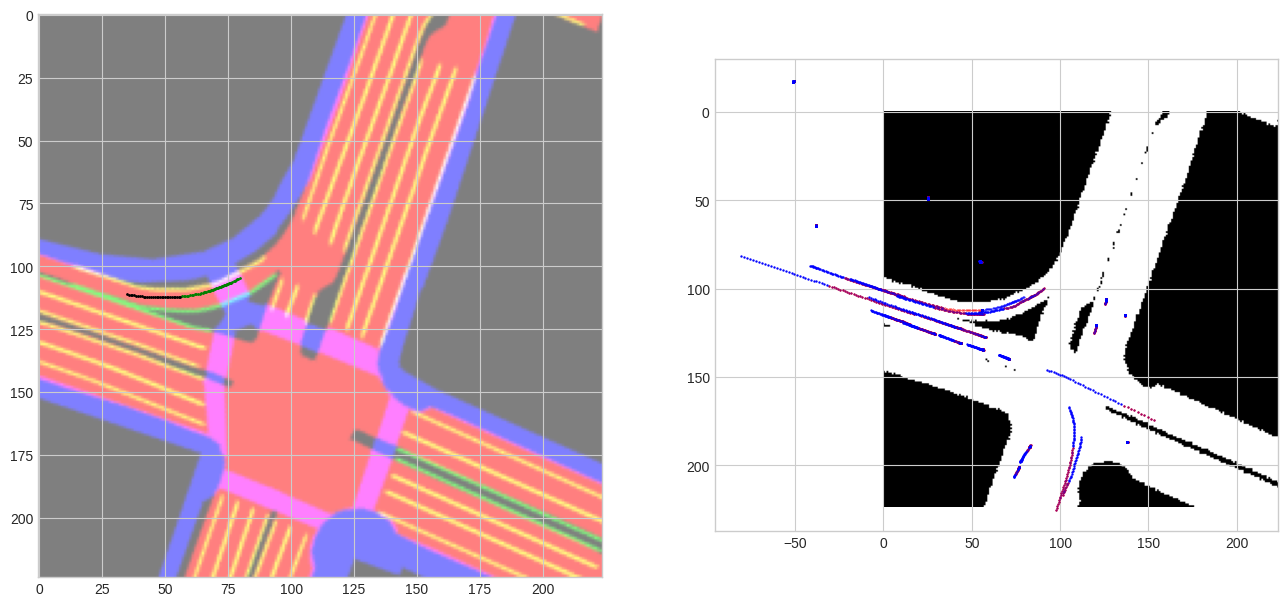

In [133]:
%matplotlib inline
idx=13

raster_from_agent = batch['raster_from_agent'][idx]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

target_avai = batch['target_availabilities'][idx].unsqueeze(-1)

image = batch['image'][idx].permute(1,2,0).cpu().numpy()
drivable_map = batch['drivable_map'][idx].cpu().numpy()

target_position = batch['target_positions'][idx]*target_avai
target_raster = transform_points(target_position,raster_from_agent)

hist_position= batch['history_positions'][idx].cpu().numpy()
hist_raster  = transform_points(hist_position,raster_from_agent)


all_agent_fut = batch['all_other_agents_future_positions'][idx]
all_fut_raster=transform_points(all_agent_fut,raster_from_agent)

all_agent_hist = batch['all_other_agents_history_positions'][idx]
all_hist_raster=transform_points(all_agent_hist,raster_from_agent)#[88,31,2]

fut_avai = batch['all_other_agents_future_availability'][idx].unsqueeze(-1)#[88,52]
mask = fut_avai.squeeze(-1).bool() 
valid_fut_points = all_fut_raster[mask]

hist_avai = batch['all_other_agents_history_availabilities'][idx].unsqueeze(-1)#
mask_hist = hist_avai.squeeze(-1).bool() 
valid_hist_points = all_hist_raster[mask_hist]


ax1.imshow(image[...,-3:]*0.5+0.5)
ax1.scatter(target_raster[:,0], target_raster[:,1], c='g', s=1, label='future')
ax1.scatter(hist_raster[:,0],hist_raster[:,1],c='black',s=1)
# a=1
# b=66
# ax1.scatter(all_fut_raster[a:b,:,0], all_fut_raster[a:b,:,1], c='b', s=0.5)
# ax1.scatter(all_hist_raster[a:b,:,0], all_hist_raster[a:b,:,1], c='r', s=0.5)

ax2.scatter(valid_fut_points[...,:,0], valid_fut_points[...,:,1], c='r', s=0.5)
ax2.scatter(valid_hist_points[...,:,0], valid_hist_points[...,:,1], c='b', s=0.5)


ax2.imshow(drivable_map, cmap="gray")
ax2.scatter(hist_raster[:,0],hist_raster[:,1],c='r',s=0.1)
ax2.scatter(target_raster[:,0], target_raster[:,1], c='b', s=0.2, label='future')


ax2.scatter(all_fut_raster[:,:,0], all_fut_raster[:,:,1], c='b', s=0.06)

valid_fut_points.shape

'\nhist_sum = hist_data.sum(axis=-1)\n\n\n\ndrivable_map = batch[\'drivable_map\'][idx].cpu().numpy()\nax2.imshow(drivable_map, cmap="gray")\nax2.set_title("Drivable Map + Future Traj")\n# hist_sum = np.sum(image[:,:, :31], axis=-1)\n\n\n\n\n\nextent = batch[\'agent_fut_extent\'][idx][:,:2].cpu().numpy()\n\nyaw = batch[\'target_yaws\'][idx].cpu().numpy()\npos = target_position.cpu().numpy()\nboxes = GeoUtils.get_box_world_coords_np(pos, yaw, extent)\n\nboxes_raster = transform_points(boxes, raster_from_agent)\nboxes_raster = boxes_raster.reshape((-1, 4, 2))\nfor bi, b in enumerate(boxes_raster):\n    cur_fill_color = get_agt_color(bi)\n    cur_outline_color = "grey"\n    rect = patches.Polygon(b, fill=True, color=cur_fill_color, zorder=3)\n    ax2.add_patch(rect)\n\nhist_position= batch[\'history_positions\'][idx].cpu().numpy()\nhist_raster  = transform_points(hist_position,raster_from_agent)\nax1.scatter(hist_raster[:,0],hist_raster[:,1],c=\'r\',s=0.1)\nnum_neigh = batch[\'neigh_indic

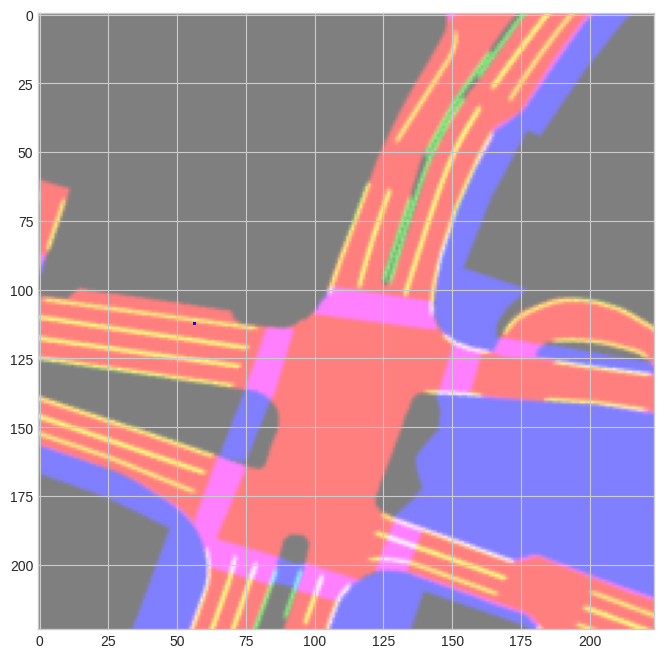

In [13]:
%matplotlib inline
idx=6
raster_from_agent = batch['raster_from_agent'][idx]
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(8,8))

image = batch['image'][idx].permute(1,2,0).cpu().numpy()
ax1.imshow(image[...,-3:]*0.5+0.5)
hist_data = image[..., :31]
target_position = batch['target_positions'][idx]
target_raster = transform_points(target_position,raster_from_agent)

ax1.scatter(target_raster[:,0], target_raster[:,1], c='b', s=1, label='future')
hist_data.shape

hist_sum = hist_data.sum(axis=-1)



drivable_map = batch['drivable_map'][idx].cpu().numpy()
ax2.imshow(drivable_map, cmap="gray")
ax2.set_title("Drivable Map + Future Traj")
# hist_sum = np.sum(image[:,:, :31], axis=-1)





extent = batch['agent_fut_extent'][idx][:,:2].cpu().numpy()

yaw = batch['target_yaws'][idx].cpu().numpy()
pos = target_position.cpu().numpy()
boxes = GeoUtils.get_box_world_coords_np(pos, yaw, extent)

boxes_raster = transform_points(boxes, raster_from_agent)
boxes_raster = boxes_raster.reshape((-1, 4, 2))
for bi, b in enumerate(boxes_raster):
    cur_fill_color = get_agt_color(bi)
    cur_outline_color = "grey"
    rect = patches.Polygon(b, fill=True, color=cur_fill_color, zorder=3)
    ax2.add_patch(rect)

hist_position= batch['history_positions'][idx].cpu().numpy()
hist_raster  = transform_points(hist_position,raster_from_agent)
ax1.scatter(hist_raster[:,0],hist_raster[:,1],c='r',s=0.1)
num_neigh = batch['neigh_indices']

yaw_hist = batch['history_yaws'][idx].cpu().numpy()
pos_hist = batch['agent_hist'][idx][:,:2].cpu().numpy()  #hist_position
extent_hist = batch['agent_hist_extent'][idx][:,:2].cpu().numpy()
boxes_hist = GeoUtils.get_box_world_coords_np(pos_hist,yaw_hist,extent_hist)
boxes_raster_hist = transform_points(boxes_hist,raster_from_agent)
boxes_raster_hist = boxes_raster_hist.reshape((-1,4,2))
for bi, b in enumerate(boxes_raster_hist):
    cur_fill_color = get_agt_color(bi+1)
    cur_outline_color = "grey"
    rect = patches.Polygon(b, fill=True, color=cur_fill_color, zorder=3)
    ax2.add_patch(rect)

for i in range(2):
    neighbor_hist = batch['neigh_hist'][idx][i,:,:2]
    neigh_raster = transform_points(neighbor_hist,raster_from_agent)
    ax1.scatter(neigh_raster[:,0], neigh_raster[:,1], c='g', s=0.05, label='future')

for i in range(2):
    neighbor_fut = batch['neigh_fut'][idx][i,:,:2]
    neigh_raster = transform_points(neighbor_fut,raster_from_agent)
    ax1.scatter(neigh_raster[:,0], neigh_raster[:,1], c='w', s=0.05, label='future')

full_traj = batch['extras']['full_fut_traj'][idx][:,:2].cpu().numpy()
full_traj_raster = transform_points(full_traj,raster_from_agent)
ax1.scatter(full_traj_raster[:,0],full_traj_raster[:,1],c='r',s=0.12)

ax3.imshow(drivable_map, cmap="gray")
# for i in range(15):
#     cur_fill_color = get_agt_color(i)
#     closest_lane = batch['extras']['closest_lane_point'][idx][i,:,:2].cpu().numpy()
#     lane_raster = transform_points(closest_lane, raster_from_agent)
#     for il in range(80):
#         ax3.scatter(lane_raster[il,0],lane_raster[il,1],c=cur_fill_color,s=0.1)
all_agents_fut = batch['all_other_agents_future_positions'][idx]
raster_all_fut = transform_points(all_agents_fut,raster_from_agent)
# for i in range(57):

#     ax3.scatter(raster_all_fut[i,:,0],raster_all_fut[i,:,1],c='r',s=0.12)

ax3.imshow(hist_data[...,3], cmap="gray")
batch['all_other_agents_future_availability'][idx].shape



In [ ]:
batch['all_other_agents_future_positions'].shape

